In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `l` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when p

In [3]:
# Install necessary libraries
!pip install transformers torch scikit-learn pandas

# Import required libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Sentiment Analysis with DistilBERT
# Load your dataset
file_path = '/content/data_predictions.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Extract 'news' column
headlines = df['news'].tolist()

# Load DistilBERT model and tokenizer (finetuned for SST-2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store results
predicted_sentiments = []
positive_probabilities = []
negative_probabilities = []

# Iterate over all headlines and make predictions
for headline in headlines:
    # Tokenize the headline
    inputs = tokenizer(headline, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted sentiment class (0: negative, 1: positive)
    sentiment_classes = ['negative', 'positive']
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    predicted_sentiment = sentiment_classes[predicted_class]

    # Get probabilities for both sentiments
    positive_probability = probabilities[0][1].item()  # Probability of positive sentiment
    negative_probability = probabilities[0][0].item()  # Probability of negative sentiment

    predicted_sentiments.append(predicted_sentiment)
    positive_probabilities.append(positive_probability)
    negative_probabilities.append(negative_probability)

# Add sentiment analysis results to the DataFrame
df['predicted_sentiment'] = predicted_sentiments
df['positive_probability'] = positive_probabilities
df['negative_probability'] = negative_probabilities

# Drop rows with missing values
df = df.dropna()

# Show the DataFrame with sentiment predictions
print(df[['news', 'predicted_sentiment', 'positive_probability', 'negative_probability']].head())

# Optionally, save the dataframe with sentiment predictions to a new CSV file
df.to_csv('/content/sentiment_predictions.csv', index=False)


                                                news predicted_sentiment  \
0           india optimistic over india inc optimism            positive   
1  make panel looking into womens marriage age ge...            positive   
2  stay at home follow covid appropriate behaviou...            negative   
3  in a win for devas shareholders canada court o...            negative   
4           notices on plea challenging manipurs ilp            positive   

   positive_probability  negative_probability  
0              0.998156              0.001844  
1              0.844012              0.155988  
2              0.065503              0.934497  
3              0.070802              0.929198  
4              0.570771              0.429229  


In [4]:
df.head()

,date,Open,High,Low,Close,Shares Traded,Turnover (â¹ Cr),news,Sentiment,predicted_sentiment,positive_probability,negative_probability
0,2022-01-03,17387.15,17646.65,17383.3,17625.7,200456430.0,16181.36,india optimistic over india inc optimism,0,positive,0.998156,0.001844
1,2022-01-03,17387.15,17646.65,17383.3,17625.7,200456430.0,16181.36,make panel looking into womens marriage age ge...,0,positive,0.844012,0.155988
2,2022-01-03,17387.15,17646.65,17383.3,17625.7,200456430.0,16181.36,stay at home follow covid appropriate behaviou...,0,negative,0.065503,0.934497
3,2022-01-03,17387.15,17646.65,17383.3,17625.7,200456430.0,16181.36,in a win for devas shareholders canada court o...,0,negative,0.070802,0.929198
4,2022-01-03,17387.15,17646.65,17383.3,17625.7,200456430.0,16181.36,notices on plea challenging manipurs ilp,0,positive,0.570771,0.429229


In [7]:
df.columns

Index(['date', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (â¹ Cr)', 'news', 'Sentiment', 'predicted_sentiment',
       'positive_probability', 'negative_probability'],
      dtype='object')

In [11]:
df.columns = df.columns.str.strip()


In [12]:
df.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Shares Traded',
       'Turnover (â¹ Cr)', 'news', 'Sentiment', 'predicted_sentiment',
       'positive_probability', 'negative_probability', 'stock_movement'],
      dtype='object')

In [24]:
# Install necessary libraries
!pip install scikit-learn pandas matplotlib seaborn

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sentiment_predictions.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)
# Remove extra spaces in column names
df.columns = df.columns.str.strip()

# Print the cleaned column names
print(df.columns)

# Prepare the target variable (stock movement)
# If the next day's close is higher than today's close, stock movement is '1' (up), otherwise '0' (down)
df['stock_movement'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop the last row because it has no 'next day' data
df = df.dropna(subset=['stock_movement'])

# Prepare features: including sentiment probabilities, Open, High, Low, Close, etc.
features = ['Open', 'High', 'Low', 'Close', 'Shares Traded', 'Turnover (â¹ Cr)', 'positive_probability', 'negative_probability']
X = df[features]
y = df['stock_movement']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict the stock movement on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))





Index(['date', 'Open', 'High', 'Low', 'Close', 'Shares Traded',
       'Turnover (â¹ Cr)', 'news', 'Sentiment', 'predicted_sentiment',
       'positive_probability', 'negative_probability'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4009
           1       0.57      0.38      0.45        77

    accuracy                           0.98      4086
   macro avg       0.78      0.69      0.72      4086
weighted avg       0.98      0.98      0.98      4086

Accuracy Score:
0.982868330885952


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


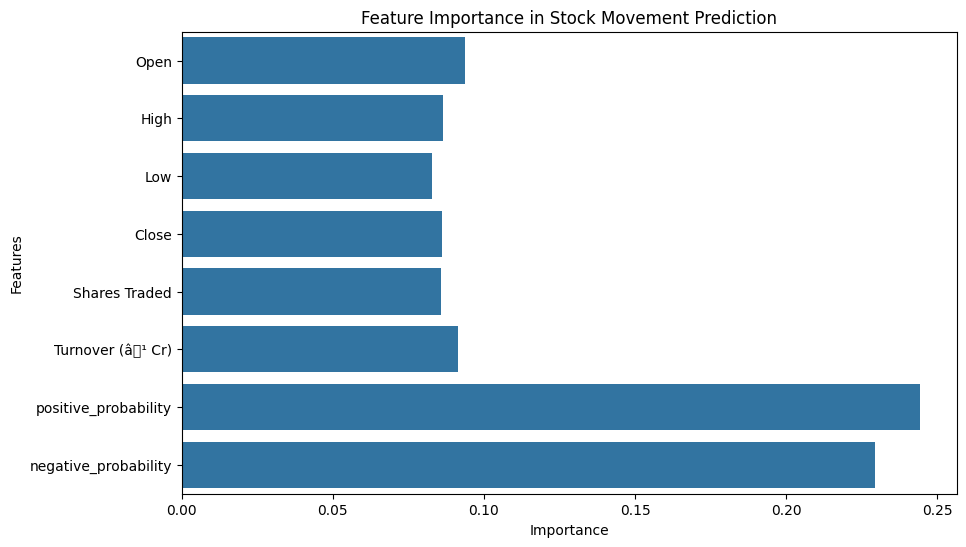

In [17]:
# Feature importance from the trained Random Forest model
importances = clf.feature_importances_
indices = X.columns

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=indices)
plt.title("Feature Importance in Stock Movement Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


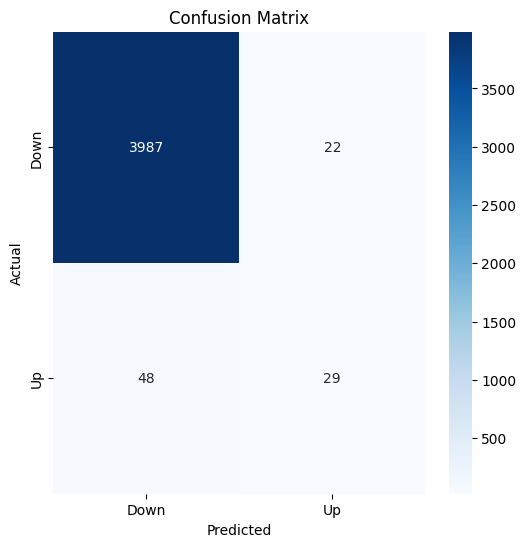

In [18]:
# Confusion Matrix (already included in the previous code)
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


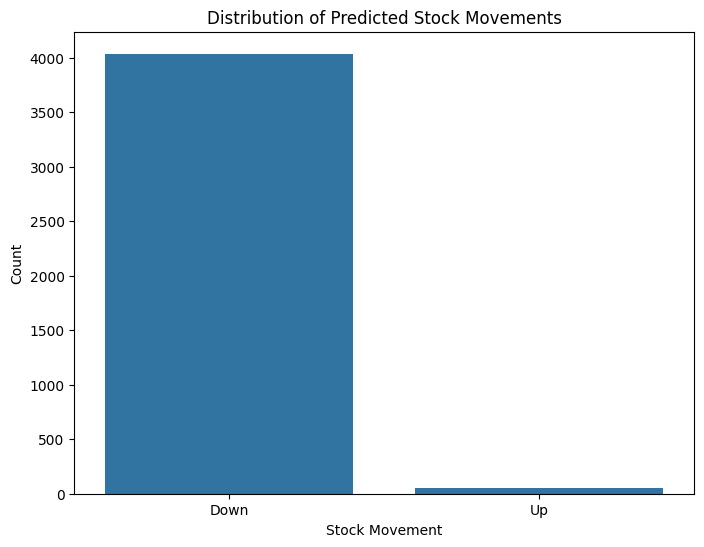

In [19]:
# Plot the distribution of predicted stock movements
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred)
plt.title("Distribution of Predicted Stock Movements")
plt.xlabel("Stock Movement")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Down", "Up"])
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


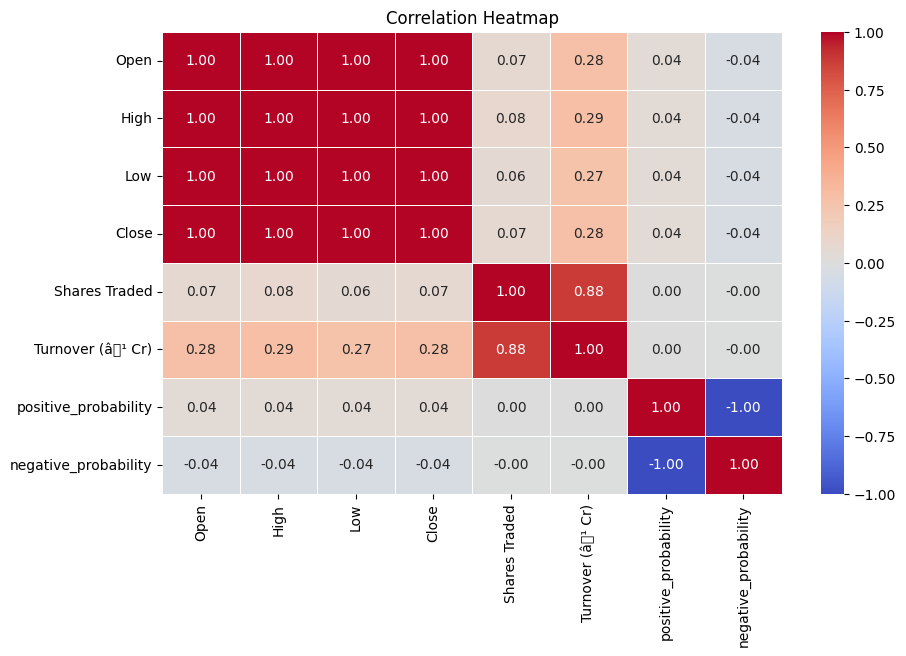

In [21]:
# Plot the correlation heatmap
correlation_matrix = df[features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


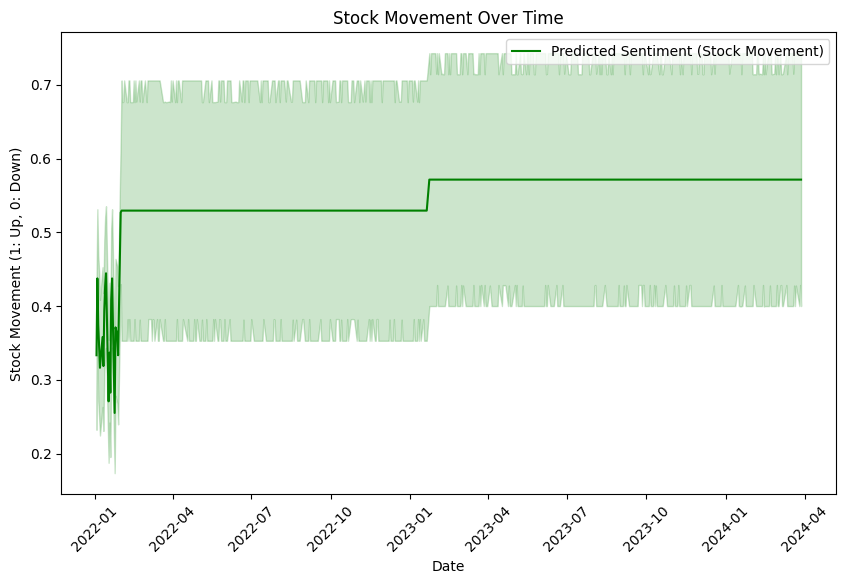

In [22]:
# Plot stock movement over time
df['date'] = pd.to_datetime(df['date'])
df['predicted_sentiment'] = df['predicted_sentiment'].map({'positive': 1, 'negative': 0})

plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='predicted_sentiment', data=df, label="Predicted Sentiment (Stock Movement)", color="green")
plt.title("Stock Movement Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Movement (1: Up, 0: Down)")
plt.xticks(rotation=45)
plt.show()
